# Lab 1 - Training a Machine Learning Model

The goal of this lab is to demonstarte how to orchestrate machine learning **training** with *Azure Machine Learning service*. 

To keep the focus of the lab on **workflow orchestration** rather then on idiosyncrasies of a domain problem, we have chosen a relatively simple machine learning scenario.

During the lab you will learn how to:
- Track training iterations a.k.a *Runs* in *Azure ML Experiment*
- Execute training scripts on powerful, cloud compute resources - *Azure ML Compute*.
- Register the best performing model with *Azure ML Model Registry*


## Scenario

You will train a binary classification model to predict propensity to purchase. The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The goal of the model is to help with campaign planning by predicting which clients will respond positively to marketing phone calls. 


## Connect AML workspace

Check the version of AML SDK.

In [1]:
# Verify AML SDK Installed

import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.0.2


Connect to the workspace.

In [2]:
from azureml.core import Workspace

# Connect to workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

Found the config file in: /data/home/demouser/notebooks/MTC_AzureAILabs/ML-AML-Walkthrough/aml_config/config.json
jkamlworkshop
jkamlworkshop
southcentralus
952a710c-8d9c-40c1-9fec-f752138cc0b3


## Data preparation
### Download the dataset
The dataset can be downloaded from a public Azure Blob Storage container.


In [3]:
import os

folder = '../datasets'
filename = 'banking.csv'
os.makedirs(folder, exist_ok=True)
downloadCommand = 'wget -O ''{0}/{1}'' ''https://azureailabs.blob.core.windows.net/banking/{1}'''.format(folder, filename)
print(downloadCommand)
os.system(downloadCommand)
os.listdir(folder)

wget -O ../datasets/banking.csv https://azureailabs.blob.core.windows.net/banking/banking.csv


['banking.csv']

### Explore the dataset


In [4]:
import numpy as np
import pandas as pd
import os

folder = '../datasets'
filename = 'banking.csv'
pathname = os.path.join(folder, filename)
df_raw = pd.read_csv(pathname, delimiter=',')
print(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usag

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


The dataset combines the information about the bank's customers with the results of previous campaigns and key economic indicators. It includes 41,188 records and 21 fields. The columns are a mix of numeric and categorical data types.

The `y` column indicates whether the customer subscribed to a term deposit. This is our `target` variable or `label`. The goal of the model is to predict this column on new examples.

Some information that exists in the historical dataset will not be available when planning a new campaign. 

Please refer to [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing) for more information. 

We will use the following features for training. 

In [5]:
feature_columns = [
                   # Demographic
                   'age', 
                   'job', 
                   'education', 
                   'marital',  
                   'housing', 
                   'loan', 
                   # Previous campaigns
                   'month',
                   'campaign',
                   'poutcome',
                   # Economic indicators
                   'emp_var_rate',
                   'cons_price_idx',
                   'cons_conf_idx',
                   'euribor3m',
                   'nr_employed']

df_raw = df_raw[feature_columns + ['y']]
df_raw.head()

,age,job,education,marital,housing,loan,month,campaign,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,basic.4y,married,yes,no,aug,1,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,unknown,married,no,no,nov,1,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,university.degree,single,yes,no,jun,3,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,high.school,married,no,no,apr,2,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,basic.4y,married,yes,no,aug,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


`Scikit-learn` estimators expect continuous input. Some of the features in the dataset are categorical and encoded as strings. We will use *dummy* encoding to convert categorical features to numeric values.

In [6]:
df = pd.get_dummies(df_raw, drop_first=True).astype(dtype='float')

Let's reserve a portion of data for testing.

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
   df, 
   test_size = 0.2,
   stratify = df['y'])

Let's now look at the class distribution in training data.

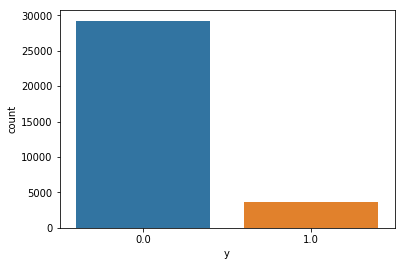

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(train.y)

The training dataset is very imbalanced. We will need to address this when configuring training.

## Train the model

In this section of the lab you will train a binary classification model.

You will first run training on a local workstation and use Azure Machine Learning Experiment to track training progress. In the following step, you will use Azure Machine Learning Compute to run  training on more powerful cloud compute resources.

In the Azure Machine Learning service, you can track training artifacts (alogorithm settings, performance metrics, logs, serialized models, etc.)  created during training iterations a.k.a *Runs* using Azure ML *Experiment*. To do that you must instrument your code with logging statements and trigger logging when you submit the *Run*. The following are two ways to trigger the run submission:

- Start an interactive logging session in the specified *Experiment*. As you execute logging statements, any artifacts that are logged during the session are added to the run record in the experiment. We will use this approach when training the model on the local compute.

- Add logging functions to your training script and trigger logging when submitting the script to run on a given compute resource. With this option, you can add monitoring code to be notified of completion or to get a visual widget to monitor. We will use this approach when training on a remote Azure Machine Learning Compute.

### Prepare training pipeline

We are going to train a binomial *LogisticRegression* regression model. *LogisticRegression* exposes a number of tuneable hyperparameters. Argueable, the most important setting is the inverse of regularization strength **C** . For the sake of simplicity, we will focus on tuning this hyperparameter when training our model. We will use *GridSearchCV* to automate the hyperparameter tuning process. 

The business goal of our model is to identify customers with high propencity to buy. As such, we want to minimize the number of false negatives - customers who were wrongly identified as ones with low propencity to buy. We want the model with a high *recall*.

Since the dataset is imbalanced we will set *class_weight* parameter to `balanced` to automatically adjust weights inversely proportional to class frequencies in in the input data.


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Create logistic regression estimater
lr = LogisticRegression(solver='lbfgs', max_iter=300, class_weight='balanced')

# Logistic regression requires feature scaling
scaler = StandardScaler()

# Create a training pipeline
pipeline = Pipeline(steps=[('scaler', scaler),
                           ('lr', lr)])

# Configure grid search
param_grid = {'lr__C': [0.1, 0.5, 1, 2, 5]}
clf = GridSearchCV(pipeline,
                   param_grid, 
                   cv=5, 
                   scoring=['recall', 'accuracy'],
                   refit = 'recall',
                   return_train_score = False
                   )
clf

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=300,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__C': [0.1, 0.5, 1, 2, 5]}, pre_dispatch='2*n_jobs',
       refit='recall', return_train_score=False,
       scoring=['recall', 'accuracy'], verbose=0)

### Run training on a local compute

Start training on a local workstation.

In [17]:
X = train.drop('y', axis=1)
y = train.y

clf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=300,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__C': [0.1, 0.5, 1, 2, 5]}, pre_dispatch='2*n_jobs',
       refit='recall', return_train_score=False,
       scoring=['recall', 'accuracy'], verbose=0)

In [20]:
clf.cv_results_

{'mean_fit_time': array([0.15895162, 0.18452621, 0.18102312, 0.18209901, 0.17724657]),
 'std_fit_time': array([0.01009018, 0.02867489, 0.01698967, 0.00476917, 0.01307957]),
 'mean_score_time': array([0.00663142, 0.00694442, 0.00753961, 0.00658607, 0.00654235]),
 'std_score_time': array([0.00020716, 0.00086963, 0.00213714, 0.00011498, 0.00029649]),
 'param_lr__C': masked_array(data=[0.1, 0.5, 1, 2, 5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lr__C': 0.1},
  {'lr__C': 0.5},
  {'lr__C': 1},
  {'lr__C': 2},
  {'lr__C': 5}],
 'split0_test_recall': array([0.59219381, 0.59219381, 0.59219381, 0.59219381, 0.59219381]),
 'split1_test_recall': array([0.60430686, 0.60430686, 0.60430686, 0.60430686, 0.60430686]),
 'split2_test_recall': array([0.66846361, 0.6671159 , 0.6671159 , 0.6671159 , 0.6671159 ]),
 'split3_test_recall': array([0.6361186 , 0.63342318, 0.63342318, 0.63342318, 0.63342318]),
 'split4_test_recall': a

Display performance metrics for each value of **C**.

In [21]:
for C, accuracy, recall in zip(clf.cv_results_['params'], clf.cv_results_['mean_test_accuracy'], clf.cv_results_['mean_test_recall']):
    print("C: {}, accuracy: {}, recall: {}".format(C, accuracy, recall))

C: {'lr__C': 0.1}, accuracy: 0.8311077389984826, recall: 0.6244734881350328
C: {'lr__C': 0.5}, accuracy: 0.8317147192716237, recall: 0.6233954437240368
C: {'lr__C': 1}, accuracy: 0.8318057663125948, recall: 0.6233954437240368
C: {'lr__C': 2}, accuracy: 0.8318361153262519, recall: 0.6233954437240368
C: {'lr__C': 5}, accuracy: 0.8319271623672231, recall: 0.6233954437240368


### Track the training results in Azure Machine Learning Experiment

Create an *Experiment* to track run records.

In [22]:
from azureml.core.experiment import Experiment

exp = Experiment(ws, "propensity_to_buy")

Since we used *GridSearchCV* to train multiple models with different setting for **C** we want to reflect this approach in a run record. The natural way is to create a hierarcical run record structure mapping directly to our grid search training regime. 

In [25]:
from azureml.core.run import Run

# Create a root run
root_run = exp.start_logging()

# Retrieve training results from GridSearchCV object and store them in child runs of the root run
for C, accuracy, recall in zip(clf.cv_results_['params'], clf.cv_results_['mean_test_accuracy'], clf.cv_results_['mean_test_recall']):
    run = root_run.child_run("Run with C set to {}".format(C))
    run.log("C", C['lr__C'])
    run.log("Accuracy", accuracy)
    run.log("Recall", recall)
    run.complete()
    print("Storing C: {} and accuracy: {} and recall: {} in Run object".format(C['lr__C'], accuracy, recall))
    
# Close the parent run in the experiment
root_run.complete()

Storing C: 0.1 and accuracy: 0.8311077389984826 and recall: 0.6244734881350328 in Run object
Storing C: 0.5 and accuracy: 0.8317147192716237 and recall: 0.6233954437240368 in Run object
Storing C: 1 and accuracy: 0.8318057663125948 and recall: 0.6233954437240368 in Run object
Storing C: 2 and accuracy: 0.8318361153262519 and recall: 0.6233954437240368 in Run object
Storing C: 5 and accuracy: 0.8319271623672231 and recall: 0.6233954437240368 in Run object


Now that you have captured history for various runs, you can review the runs. You could use the Azure Portal for this. You can also use the AML SDK to query the runs.

In [34]:
# List all child runs
runs = [r for r in root_run.get_children()]

for run in runs:
    print(run.get_details())
    print(run.get_metrics())
    print("-" * 60)

{'runId': '2d966521-d85a-4a71-ba2f-10bd85fe2f25', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2019-01-05T00:00:06.49753Z', 'endTimeUtc': '2019-01-05T00:00:06.856446Z', 'properties': {}, 'logFiles': {}}
{'C': 5, 'Accuracy': 0.8319271623672231, 'Recall': 0.6233954437240368}
------------------------------------------------------------
{'runId': 'eafd86ce-f3ed-4d75-bab8-c59318776776', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2019-01-05T00:00:05.612279Z', 'endTimeUtc': '2019-01-05T00:00:06.04868Z', 'properties': {}, 'logFiles': {}}
{'C': 2, 'Accuracy': 0.8318361153262519, 'Recall': 0.6233954437240368}
------------------------------------------------------------
{'runId': 'bd8a3c38-526a-4a61-825d-ce13939a5d93', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2019-01-05T00:00:04.483448Z', 'endTimeUtc': '2019-01-05T00:00:04.854858Z', 'properties': {}, 'logFiles': {}}
{'C': 1, 'Accuracy': 0.8318057663125948, 'Recall': 0.6233954437240368}
-------------------

## Train remotely using Azure ML Compute

Up until now, all of your training was executed locally on the same machine running Jupyter. Now you will execute the same logic targeting a remote Azure ML Compute, which you will provision from code.

### Provision Azure ML Compute Cluster

We will provision an autoscale Azure ML Computer Cluster. In this lab we will only use a single node on the cluster. In the following labs we will multiple nodes on the cluster to run parallel model selection and hyper parameter tuning jobs.

In [35]:
# Create an Azure ML Compute cluster

# Create Azure ML cluster
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
cluster_name = "cpu-cluster"
cluster_min_nodes = 1
cluster_max_nodes = 3
vm_size = "STANDARD_DS11_V2"

if cluster_name in ws.compute_targets:
    compute_target = ws.compute_targets[cluster_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('Found existing compute target, using this compute target instead of creating:  ' + cluster_name)
    else:
        print("Error: A compute target with name ",cluster_name," was found, but it is not of type AmlCompute.")
else:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size, 
                                                                min_nodes = cluster_min_nodes, 
                                                                max_nodes = cluster_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current BatchAI cluster status, use the 'status' property    
    print(compute_target.status.serialize())

Creating a new compute target...
Creating
Succeeded.................
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-01-05T00:10:11.990000+00:00', 'creationTime': '2019-01-05T00:07:58.151689+00:00', 'currentNodeCount': 1, 'errors': None, 'modifiedTime': '2019-01-05T00:08:36.633395+00:00', 'nodeStateCounts': {'idleNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0, 'preparingNodeCount': 1, 'runningNodeCount': 0, 'unusableNodeCount': 0}, 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 1, 'maxNodeCount': 3, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'targetNodeCount': 1, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_DS11_V2'}


With your cluster ready, you need to upload the training data to the default DataStore for your AML Workspace (which uses Azure Storage). 

In [36]:
# Upload the dataset to the DataStore

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
ds.upload(src_dir='../datasets', target_path='banking', overwrite=True, show_progress=True)

AzureBlob jkamlworstoragebvcqonoz azureml-blobstore-77114569-d741-41ff-81b0-43cf36590b03


$AZUREML_DATAREFERENCE_80479c3fd7944b88bbff63208482eda0

Next, you will need to create a training script that is similar to the code you have executed locally to train the model. 

In [ ]:
import os
script_folder = './script'
os.makedirs(script_folder, exist_ok=True)

In [ ]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import pandas as pd

from sklearn import linear_model 
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from azureml.core import Run

# let user feed in 2 parameters, the location of the data files (from datastore), and the training set percentage to use
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--C', type=float, dest='C', default=1, help='regularization')
args = parser.parse_args()

data_folder = os.path.join(args.data_folder, 'used_cars')
print('Data folder:', data_folder)
data_csv_path = os.path.join(data_folder, 'UsedCars_Clean.csv')
print('Path to CSV file dataset:' + data_csv_path)

# Load the data
#df = pd.read_csv('UsedCars_Clean.csv', delimiter=',')
df = pd.read_csv(data_csv_path)
df['Affordable'] = np.where(df['Price']<12000, 1, 0)
df_affordability = df[["Age","KM", "Affordable"]]


# Now experiment with different training subsets
from sklearn.model_selection import train_test_split
full_X = df_affordability[["Age", "KM"]]
full_Y = df_affordability[["Affordable"]]

def train_eval_model(full_X, full_Y,training_set_percentage, C):
    train_X, test_X, train_Y, test_Y = train_test_split(full_X, full_Y, train_size=training_set_percentage, random_state=42)
    
    # Flatten labels
    train_Y = np.ravel(train_Y)
    test_Y = np.ravel(test_Y)
    
    # Convert to float
    train_X = train_X.astype(float)
    test_X = test_X.astype(float)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_X)
    clf = linear_model.LogisticRegression(C=C, solver='lbfgs')
    clf.fit(X_scaled, train_Y)

    scaled_inputs = scaler.transform(test_X)
    predictions = clf.predict(scaled_inputs)
    score = accuracy_score(test_Y, predictions)

    return (clf, score)

# Acquire the current run
run = Run.get_context()


training_set_percentage = args.training_set_percentage
C = args.C
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {})".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)


# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/model.pkl')


Create an estimator that descrives the configuration of the job that will execute your model training script.

In [ ]:
# Create estimator
#############################
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
    '--training-set-percentage': 0.3,
    '--C': 2
}

est_config = Estimator(source_directory=script_folder,
                       script_params=script_params,
                       compute_target=compute_target,
                       entry_script='train.py',
                       conda_packages=['scikit-learn', 'pandas'])

Submit the job using the submit() method of the Experiment object. 

In [ ]:
#  Execute the estimator job
#####################################

# Create new experiment
from azureml.core import Experiment
experiment_name = "usedcars_training_amlcompute"
exp = Experiment(workspace=ws, name=experiment_name)

run = exp.submit(config=est_config)
run


You can monitor the job through Azure Portal or using AML Jupyter Widget.

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()


In [ ]:
# Poll for job status
run.wait_for_completion(show_output=True)  # value of True will display a verbose, streaming log

# Examine the recorded metrics from the run
print(run.get_metrics())